In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import requests

from selenium import webdriver
from selenium.common.exceptions import (TimeoutException,
    NoSuchAttributeException, WebDriverException)
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.firefox.options import Options as firefox_Options
from selenium.webdriver.chrome.options import Options as chrome_Options

from bs4 import BeautifulSoup

In [82]:
html = requests.get('https://blog.landot-avocats.net/category/breves-et-articles/').text

In [83]:
soup = BeautifulSoup(html, 'html.parser')
titles = [_.text for _ in soup.find_all('h1')]
titles

['\n\n\n',
 '\nCategory Archive:  Brèves et articles\t\t\t\t\t',
 'Pilotage et encadrement du recours aux prestations intellectuelles informatiques (PII) : une circulaire de vive mise au carré d’un type d’achats de l’Etat devenu, à tout le moins, très sensible\n',
 'AirBnB et autres meublés de tourisme : jurisprudences sur le régime d’autorisation (art. L. 631-7 s. du CCH) [VIDEO et article]\n',
 'Un CBCM peut déléguer sa signature de comptable public aux agents du département comptable ministériel (DCM)\n',
 'Rapatriement des djihadistes de Syrie et/ou de leurs enfants : le TA de Paris refuse le droit au recours imposé par la Cour de Strasbourg.\n',
 'Policiers municipaux : deux décrets modifient les conditions de recrutement dans la FPT.\n',
 'Qu’est-ce qu’un délai raisonnable pour adopter un texte réglementaire ? [VIDEO et article]\n',
 'Signature du 6e contrat de présence postale territoriale (2023-2025) par La Poste, l’Etat et l’AMF\n',
 'Le favoritisme peut frapper les influenceu

In [84]:
html = requests.get('https://www.legifrance.gouv.fr/ceta/id/CETATEXT000043754044').text

In [3]:
driver = webdriver.Firefox()
driver.get('https://www.legifrance.gouv.fr/ceta/id/CETATEXT000043754044')
# driver.find_element(By.XPATH, '/html/body/div[1]/div/main/div/div/div[2]').
html = driver.page_source
driver.close()

WebDriverException: Message: Process unexpectedly closed with status 1


In [16]:
options = chrome_Options()
options.add_experimental_option("useAutomationExtension", False)
options.add_experimental_option("excludeSwitches",["enable-automation"])
options.headless = True
driver = webdriver.Chrome(options=options)
driver.get('https://www.legifrance.gouv.fr/ceta/id/CETATEXT000047563600?init=true&page=1&query=&searchField=ALL&tab_selection=cetat')
title = driver.find_element(By.XPATH, '*//h1').text
html = driver.page_source
print(title)
# driver.close()

/tmp/ipykernel_278183/915052798.py:4: DeprecationWarning: headless property is deprecated, instead use add_argument('--headless') or add_argument('--headless=new')
  options.headless = True


CAA de TOULOUSE, Juge des référés, 17/05/2023, 23TL00998, Inédit au recueil Lebon


In [86]:
soup = BeautifulSoup(html, 'html.parser')

In [87]:
soup

<html class="js svg fontface" dir="ltr" lang="fr" style=""><head><title>Conseil d'État, 6ème - 5ème chambres réunies, 01/07/2021, 427301, Publié au recueil Lebon - Légifrance</title><meta charset="utf-8"/><meta content="IE=edge" http-equiv="X-UA-Compatible"/><meta content="width=device-width, initial-scale=1" name="viewport"/><meta content="Conseil d'État, 6ème - 5ème chambres réunies, 01/07/2021, 427301, Publié au recueil ..." name="description"/><meta content="" name="author"/><meta content="telephone=no" name="format-detection"/><meta content="0ed16f59-fc6d-4c95-8151-3f30839fd48d" name="_csrf"/><meta content="X-CSRF-TOKEN" name="_csrf_header"/><meta content="index, follow" name="robots"/><link href="/resources/images/favicon.ico" rel="Shortcut icon" type="image/x-icon"/><link href="/resources/images/favicon.ico" rel="icon" sizes="16x16 32x32 48x48 64x64"/><link href="/resources/images/favicon-152.png" rel="apple-touch-icon"/><!--  		Optional: IE10 Tile.  --><meta content="#FFFFFF" n

In [88]:
def is_main_title(tag):
    if tag.class_:
        return tag.class_=='main-title'
    else:
        return False
    
titles = [_.find_all(is_main_title) for _ in soup.find_all('h1')]

temp_name = soup.find('h1', class_='main-title').text


In [89]:
mapper = {
    'Conseil d\'État': 'CE.',
    'chambres réunies': 'chr.',
    'Publié au recueil Lebon': 'Leb.'
}
for key, val in mapper.items():
    temp_name = temp_name.replace(key, val)

temp_name

'CE., 6ème - 5ème chr., 01/07/2021, 427301, Leb.'

# Questions UMO

In [90]:
import extract_msg
import pathlib
import json
import re
import pandas as pd
from slugify import slugify
import unicodedata

In [91]:
# Extraire/lire les mails du dossier local.
# Générer une liste de dictionnaire pour le montage d'un dataframe.
emails = []
for folder in pathlib.Path('data/UMO/').glob('*'):
    for file in folder.glob('*.msg'):
        temp_json = json.loads(extract_msg.openMsg(file).getJson())
        temp_json['category'] = str(folder).split('/')[-1]
        emails.append(temp_json)

In [92]:
# Créer un dataframe et ajouter les colonnes utiles.
df = pd.DataFrame(emails)
df['raw_question'] = ''
df['norm_question'] = ''
df['auto_tags'] = ''
df['question_from'] = ''

In [93]:
# Nettoyer la colonne category.
df['category'] = df['category'].str.replace('(\d+\.)(.*)', '\\2', regex=True).str.lower()

In [94]:
# Nettoyer/formatter les dates.
months_mapper = {
    ' Jan ':'-01-',
    ' Feb ':'-02-',
    ' Mar ':'-03-',
    ' Apr ':'-04-',
    ' May ':'-05-',
    ' Jun ':'-06-',
    ' Jul ':'-07-',
    ' Aug ':'-08-',
    ' Sep ':'-09-',
    ' Oct ':'-10-',
    ' Nov ':'-11-',
    ' Dec ':'-12-',
}
df['date'] = df['date'].str.replace('(.*,)(.*)(\d{2}:\d{2}:\d{2}.*)', '\\2', regex=True)

for month, repl in months_mapper.items():
    filt = df['date'].str.contains(month)
    df.loc[filt, 'date'] = df['date'].str.replace(month, repl)

def reverse_date_format(dd_mm_yyyy_date):
    split_date = dd_mm_yyyy_date.split('-')[::-1]
    return '-'.join(split_date)

df['date'] = df['date'].apply(reverse_date_format)
df

,from,to,cc,bcc,subject,date,body,category,raw_question,norm_question,auto_tags,question_from
0,service.juridique@umo.asso.fr,Auriane Coquatrix <a.coquatrix@umo.asso.fr>,'Xavier Boissy' <x.boissy@boissyavocats.com>; ...,,RE: Question UMO - CCVT - Publicité des actes,2022 -10- 07,"Chère Madame, \r\n\r\n \r\n\r\nFaisant suite à...",autres questions,,,,
1,Xavier Boissy,Auriane Coquatrix <a.coquatrix@umo.asso.fr>,BOISSY AVOCATS <m.herlin@boissyavocats.com>; t...,,TR: Questions UMO - TILLE - Reprise concession...,2022 -11- 22,"\r\n\r\nChère Madame,\r\n\r\n \r\n\r\nFaisant...",autres questions,,,,
2,service.juridique@umo.asso.fr,Auriane Coquatrix <a.coquatrix@umo.asso.fr>,'BOISSY AVOCATS' <m.herlin@boissyavocats.com>;...,,RE: Question UMO - FOURNIVAL - Bien en état d'...,2022 -05- 30,"Chère Madame, \r\n\r\n \r\n\r\nJe fais suite à...",autres questions,,,,
3,service.juridique@umo.asso.fr,'Auriane Coquatrix' <a.coquatrix@umo.asso.fr>,'Mathieu HERLIN' <m.herlin@boissyavocats.com>;...,,RE: Question UMO - LEVIGNEN- Conforme à l'orig...,2022 -06- 29,"Chère Madame, \r\n\r\n \r\n\r\nFaisant suite à...",autres questions,,,,
4,Xavier Boissy,Sébastien Piatkowski - Directeur <s.piatkowski...,BOISSY AVOCATS <m.herlin@boissyavocats.com>; t...,,RE: Beaurain les noyon - Escroquerie Cabinet d...,2022 -09- 27,\r\n\r\n \r\n\r\n \r\n\r\nMonsieur le Directe...,autres questions,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...
1126,Mathieu HERLIN,Auriane Coquatrix <a.coquatrix@umo.asso.fr>,Emmanuelle GREVOT <e.grevot@maestroavocats.fr>...,,RE: Question UMO - BONVILLERS - Indemnité infl...,2021 -11- 10,"Chère Madame,\r\n\r\n \r\n\r\nLes modalités de...",collectivités,,,,
1127,Mathieu HERLIN,Sébastien Piatkowski - Directeur <s.piatkowski...,Emmanuelle GREVOT <e.grevot@maestroavocats.fr>...,,RE: RE : Re: RE : RE: renseignements,2021 -11- 19,"Monsieur le Directeur,\r\n\r\n \r\n\r\nLacqui...",collectivités,,,,
1128,Xavier Boissy,Sébastien Piatkowski - Directeur <s.piatkowski...,BOISSY AVOCATS <m.herlin@boissyavocats.com>; e...,,RE: Laversines - Ouverture commerce à domicile,2022 -03- 16,"Monsieur le Directeur,\r\n\r\n \r\n\r\nNous fa...",collectivités,,,,
1129,service.juridique@umo.asso.fr,'Auriane Coquatrix' <a.coquatrix@umo.asso.fr>,'Mathieu HERLIN' <m.herlin@boissyavocats.com>;...,,RE: Question UMO - VILLERS SUR COUDUN - Organi...,2022 -07- 06,"Chère Madame, \r\n\r\n \r\n\r\nL'organisation ...",collectivités,,,,


In [95]:
# Nettoyer l'objet des messages.
df['subject'] = df['subject'].str.lower()
mail_marks = ['re:', 're :', 'tr:', 'fwd:', 'question umo', 'umo -']
for mark in mail_marks:
    filt = df['subject'].str.contains(mark)
    df.loc[filt, 'subject'] = df['subject'].str.replace(mark, '').str.strip(' -')

In [96]:
# Nettoyer le corps des messages.
def split_email(email_text):
    mail_splitter = 'De : [^\r\n]+[\r\n]+Envoyé : [^\r\n]+[\r\n]+À : [^\r\n]+[\r\n]+'
    return re.sub(mail_splitter, '\nMAIL_SPLITTER\n', email_text).split('\nMAIL_SPLITTER\n')

def compute_email_length(email_text):
    return len(split_email(email_text))

def get_answer(email_text):
    return split_email(email_text)[0]
df['raw_question'].str.contains(f' city ', case=False,  regex=False)
def get_raw_question(email_text):
    return split_email(email_text)[-1]

df['conv_length'] = df['body'].apply(compute_email_length)

In [97]:
# Extraire question originale et réponse finale du corps du message.
df['temp_answer'] = df['body'].apply(get_answer)
df['raw_question'] = df['body'].apply(get_raw_question)

In [98]:
# Nettoyer les colonnes avec des emails.
def extract_email_adress(raw_text):
    email_pattern = "[a-zA-Z0-9.!#$%&'*+/=?^_`{|}~-]+@[a-zA-Z0-9-]+(?:\.[a-zA-Z0-9-]+)*"
    return ' ; '. join(re.findall(email_pattern, raw_text))

df['cc'] = df['cc'].apply(extract_email_adress)
df['to'] = df['to'].apply(extract_email_adress)

In [99]:
df.raw_question[200]

'Bonjour, \r\n\r\nVous trouverez ci-dessous une sollicitation de la commune d\'Eve.\r\n\r\nVous en souhaitant bonne réception, \r\n\r\nSincèrement, \r\n\r\n---\r\n\r\n\r\nAuriane Coquatrix\r\n\r\nJuriste\r\n\r\nTel : 03 44 45 15 51\r\n\r\n\r\n\r\n\r\n\r\n\r\n-------- Courriel original --------\r\n\r\nObjet:\t COURRIER STE ANETT\t \r\nDate:\t 07.10.2021 16:18\t \r\nDe:\t Mairie d\'Eve <mairie.eve@orange.fr>\t \r\nÀ:\t "a.coquatrix@umo.asso.fr" <a.coquatrix@umo.asso.fr>\t \r\n\r\n\r\n\r\n\r\nBonjour,\r\n\r\nComme suite à notre entretien pourriez-vous nous indiquer la marche à suivre pour répondre à cette société\r\n\r\nBien cordialement\r\n\r\n Y DUBREUIL\r\n\r\nSecrétaire de mairie de Eve\r\n\r\n \r\n\r\nA compter du 12 juillet 2021, merci d\'adresser vos mails à la nouvelle adresse : contact@mairie-eve.fr <mailto:contact@mairie-eve.fr> \r\n\r\n \r\n\r\n03.44.60.52.01\r\n\r\n \r\n\r\n\r\n\r\n \r\n\r\n'

In [100]:
rgx_objet = re.compile('(.*)(objet\s:[^\r]+)(.*)', re.DOTALL|re.IGNORECASE)
print(rgx_objet.search(df.raw_question[400]).expand('\\3').strip())

Maître, 

Voici une question complémentaire suite à votre réponse pour Ponchon.

Bien à vous.

---

	Sébastien Piatkowski

	Directeur

	Tel : 03 44 45 15 51

	 <https://mail.ovh.net/roundcube/?_task=mail&_action=get&_mbox=INBOX.Conseil+juridique&_uid=1&_token=2PhUJ0tckNW1z5JaUw0m5xDiKrap0iBe&_part=2.2&_embed=1&_mimeclass=image> 

 

-------- Courriel original --------

Objet:

Re: Renseignements conseil municipal

Date:

08.07.2022 17:58

De:

Yannig Merlin <yannig.merlin@ponchon.fr <mailto:yannig.merlin@ponchon.fr> >

À:

Sébastien Piatkowski - Directeur <s.piatkowski3@umo.asso.fr <mailto:s.piatkowski3@umo.asso.fr> >

 

Bonjour Monsieur,

 

Je vous remercie de cette réponse, si je peux encore abuser de vos services, dans notre cas, après cette nouvelle nomination, il ne restera plus qu'un élu "supplémentaire" sur notre liste initiale, si 2 nouvelles démissions intervenaient, il n'y aurait plus de "remplaçant" faudrait-il attendre qu'il ne reste plus que 10 membres sur 15 pour provoq

In [101]:
df.to_csv('UMO_test.csv', sep='\t')

In [102]:
df

,from,to,cc,bcc,subject,date,body,category,raw_question,norm_question,auto_tags,question_from,conv_length,temp_answer
0,service.juridique@umo.asso.fr,a.coquatrix@umo.asso.fr,x.boissy@boissyavocats.com ; x.peres@maestroav...,,ccvt - publicité des actes,2022 -10- 07,"Chère Madame, \r\n\r\n \r\n\r\nFaisant suite à...",autres questions,Cc : Contact Direction <contact-direction@vexi...,,,,5,"Chère Madame, \r\n\r\n \r\n\r\nFaisant suite à..."
1,Xavier Boissy,a.coquatrix@umo.asso.fr,m.herlin@boissyavocats.com ; t.dubois@boissyav...,,questions tille - reprise concessions et enga...,2022 -11- 22,"\r\n\r\nChère Madame,\r\n\r\n \r\n\r\nFaisant...",autres questions,Objet : Questions UMO - TILLE - Reprise conces...,,,,2,"\r\n\r\nChère Madame,\r\n\r\n \r\n\r\nFaisant..."
2,service.juridique@umo.asso.fr,a.coquatrix@umo.asso.fr,m.herlin@boissyavocats.com ; x.boissy@boissyav...,,fournival - bien en état d'abandon et projet d...,2022 -05- 30,"Chère Madame, \r\n\r\n \r\n\r\nJe fais suite à...",autres questions,Objet : Question UMO - FOURNIVAL - Bien en éta...,,,,2,"Chère Madame, \r\n\r\n \r\n\r\nJe fais suite à..."
3,service.juridique@umo.asso.fr,a.coquatrix@umo.asso.fr,m.herlin@boissyavocats.com ; x.boissy@boissyav...,,levignen- conforme à l'original,2022 -06- 29,"Chère Madame, \r\n\r\n \r\n\r\nFaisant suite à...",autres questions,Objet : Question UMO - LEVIGNEN- Conforme à l'...,,,,2,"Chère Madame, \r\n\r\n \r\n\r\nFaisant suite à..."
4,Xavier Boissy,s.piatkowski3@umo.asso.fr,m.herlin@boissyavocats.com ; t.dubois@boissyav...,,beaurain les noyon - escroquerie cabinet d'étude.,2022 -09- 27,\r\n\r\n \r\n\r\n \r\n\r\nMonsieur le Directe...,autres questions,Objet : Fwd: Beaurain les noyon - Escroquerie ...,,,,2,\r\n\r\n \r\n\r\n \r\n\r\nMonsieur le Directe...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1126,Mathieu HERLIN,a.coquatrix@umo.asso.fr,e.grevot@maestroavocats.fr ; x.boissy@boissyav...,,bonvillers - indemnité inflation,2021 -11- 10,"Chère Madame,\r\n\r\n \r\n\r\nLes modalités de...",collectivités,Objet : Question UMO - BONVILLERS - Indemnité ...,,,,2,"Chère Madame,\r\n\r\n \r\n\r\nLes modalités de..."
1127,Mathieu HERLIN,s.piatkowski@umo.asso.fr,e.grevot@maestroavocats.fr ; x.boissy@boissyav...,,renseignements,2021 -11- 19,"Monsieur le Directeur,\r\n\r\n \r\n\r\nLacqui...",collectivités,Cc : service.juridique@umo.asso.fr; bruno.cale...,,,,2,"Monsieur le Directeur,\r\n\r\n \r\n\r\nLacqui..."
1128,Xavier Boissy,s.piatkowski3@umo.asso.fr,m.herlin@boissyavocats.com ; e.grevot@maestroa...,,laversines - ouverture commerce à domicile,2022 -03- 16,"Monsieur le Directeur,\r\n\r\n \r\n\r\nNous fa...",collectivités,Objet : Laversines - Ouverture commerce à domi...,,,,2,"Monsieur le Directeur,\r\n\r\n \r\n\r\nNous fa..."
1129,service.juridique@umo.asso.fr,a.coquatrix@umo.asso.fr,m.herlin@boissyavocats.com ; x.boissy@boissyav...,,villers sur coudun - organisation de marchés,2022 -07- 06,"Chère Madame, \r\n\r\n \r\n\r\nL'organisation ...",collectivités,Objet : Question UMO - VILLERS SUR COUDUN - Or...,,,,2,"Chère Madame, \r\n\r\n \r\n\r\nL'organisation ..."


In [103]:
# récupérer les villes

In [104]:
cities = pd.read_csv('data/georef-france-commune-millesime.csv', sep=';')
print(cities.columns)

Index(['Geo Point', 'Geo Shape', 'Année', 'Code Officiel Région',
       'Nom Officiel Région', 'Code Officiel Département',
       'Nom Officiel Département',
       'Code Officiel Arrondissement départemental',
       'Nom Officiel Arrondissement départemental',
       'Code Officiel Zone emploi 2020', 'Nom Officiel Zone emploi 2020',
       'Code Officiel Bassin vie 2012', 'Nom Officiel Bassin vie 2012',
       'Code Officiel EPCI', 'Nom Officiel EPCI', 'Code Officiel EPT',
       'Nom Officiel EPT', 'Code Officiel Commune',
       'Code Officiel Courant Commune', 'Nom Officiel Commune',
       'Nom Officiel Commune Majuscule', 'Nom Officiel Commune Minuscule',
       'Code Iso 3166-3 Zone', 'Type', 'com_ze2010_name', 'com_ze2010_code',
       'Code CATAEU2010', 'Libellé CATAEU2010', 'Code UU2010',
       'Statut Commune UU2010', 'Code AU2010', 'Code CATEAAV2020',
       'Libellé CATEAAV2020', 'Code UU2020', 'Statut Commune UU2020',
       'Code AAV2020', 'Code Canton Ville', 'Fait 

In [105]:
filt = cities['Nom Officiel Département'] == 'Oise'
oise_cities = cities[filt][['Code Officiel Département','Nom Officiel Département', 'Code Officiel Courant Commune', 'Nom Officiel Commune', 'Nom Officiel Commune Majuscule', 'Nom Officiel Commune Minuscule']]
oise_cities

,Code Officiel Département,Nom Officiel Département,Code Officiel Courant Commune,Nom Officiel Commune,Nom Officiel Commune Majuscule,Nom Officiel Commune Minuscule
986,60,Oise,60001,Abancourt,ABANCOURT,abancourt
987,60,Oise,60005,Acy-en-Multien,ACY-EN-MULTIEN,acy-en-multien
988,60,Oise,60010,Amblainville,AMBLAINVILLE,amblainville
989,60,Oise,60135,Cauvigny,CAUVIGNY,cauvigny
990,60,Oise,60139,Chambly,CHAMBLY,chambly
...,...,...,...,...,...,...
34020,60,Oise,60550,Rothois,ROTHOIS,rothois
34021,60,Oise,60590,Saint-Omer-en-Chaussée,SAINT-OMER-EN-CHAUSSÉE,saint-omer-en-chaussée
34022,60,Oise,60645,Trie-la-Ville,TRIE-LA-VILLE,trie-la-ville
34023,60,Oise,60676,Ville,VILLE,ville


In [106]:
def slugify_(text):
    return slugify(text)

In [107]:
oise_cities['commune_slug'] = oise_cities['Nom Officiel Commune Minuscule'].apply(slugify_)

NameError: name 'unicode' is not defined

In [ ]:
oise_cities

,Code Officiel Département,Nom Officiel Département,Code Officiel Courant Commune,Nom Officiel Commune,Nom Officiel Commune Majuscule,Nom Officiel Commune Minuscule,commune_slug
986,60,Oise,60001,Abancourt,ABANCOURT,abancourt,abancourt
987,60,Oise,60005,Acy-en-Multien,ACY-EN-MULTIEN,acy-en-multien,acy-en-multien
988,60,Oise,60010,Amblainville,AMBLAINVILLE,amblainville,amblainville
989,60,Oise,60135,Cauvigny,CAUVIGNY,cauvigny,cauvigny
990,60,Oise,60139,Chambly,CHAMBLY,chambly,chambly
...,...,...,...,...,...,...,...
34020,60,Oise,60550,Rothois,ROTHOIS,rothois,rothois
34021,60,Oise,60590,Saint-Omer-en-Chaussée,SAINT-OMER-EN-CHAUSSÉE,saint-omer-en-chaussée,saint-omer-en-chaussée
34022,60,Oise,60645,Trie-la-Ville,TRIE-LA-VILLE,trie-la-ville,trie-la-ville
34023,60,Oise,60676,Ville,VILLE,ville,ville


In [ ]:
cities = oise_cities['Nom Officiel Commune Minuscule'].sort_values(key=lambda x: -x.str.len()).to_list()
cities

['villers-saint-frambourg-ognon',
 'élincourt-sainte-marguerite',
 'hadancourt-le-haut-clocher',
 'le plessier-sur-saint-just',
 'pierrefitte-en-beauvaisis',
 'la neuville-saint-pierre',
 "lachaussée-du-bois-d'écu",
 'saint-crépin-ibouvillers',
 'saint-aubin-sous-erquery',
 'lachapelle-sous-gerberoy',
 'maisoncelle-saint-pierre',
 'la villeneuve-sous-thury',
 'montagny-sainte-félicité',
 'saint-germain-la-poterie',
 'villers-saint-barthélemy',
 'le coudray-saint-germer',
 'marseille-en-beauvaisis',
 'villeneuve-sur-verberie',
 'cambronne-lès-ribécourt',
 'mortefontaine-en-thelle',
 'la neuville-sur-oudeuil',
 'saint-andré-farivillers',
 'saint-samson-la-poterie',
 'la neuville-sur-ressons',
 'saint-vaast-de-longmont',
 'lachapelle-saint-pierre',
 'saint-just-en-chaussée',
 'villeneuve-les-sablons',
 'ribécourt-dreslincourt',
 'villers-sous-saint-leu',
 'thieuloy-saint-antoine',
 'le mesnil-saint-firmin',
 "le plessis-patte-d'oie",
 'beaulieu-les-fontaines',
 'saint-pierre-lès-bitry',
 

In [ ]:
for city in cities:
    filt = (df['raw_question'].str.contains(f' city ', case=False,  regex=False)) && (df['question_from'] == '')
    df.loc[filt, 'question_from'] = city

,from,to,cc,bcc,subject,date,body,category,raw_question,norm_question,auto_tags,question_from,conv_length,temp_answer
0,service.juridique@umo.asso.fr,a.coquatrix@umo.asso.fr,x.boissy@boissyavocats.com ; x.peres@maestroav...,,ccvt - publicité des actes,07-10-2022,"Chère Madame, \r\n\r\n \r\n\r\nFaisant suite à...",0. Autres questions,Cc : Contact Direction <contact-direction@vexi...,,,vez,5,"Chère Madame, \r\n\r\n \r\n\r\nFaisant suite à..."
1,Xavier Boissy,a.coquatrix@umo.asso.fr,m.herlin@boissyavocats.com ; t.dubois@boissyav...,,questions tille - reprise concessions et enga...,22-11-2022,"\r\n\r\nChère Madame,\r\n\r\n \r\n\r\nFaisant...",0. Autres questions,Objet : Questions UMO - TILLE - Reprise conces...,,,tillé,2,"\r\n\r\nChère Madame,\r\n\r\n \r\n\r\nFaisant..."
2,service.juridique@umo.asso.fr,a.coquatrix@umo.asso.fr,m.herlin@boissyavocats.com ; x.boissy@boissyav...,,fournival - bien en état d'abandon et projet d...,30-05-2022,"Chère Madame, \r\n\r\n \r\n\r\nJe fais suite à...",0. Autres questions,Objet : Question UMO - FOURNIVAL - Bien en éta...,,,fournival,2,"Chère Madame, \r\n\r\n \r\n\r\nJe fais suite à..."
3,service.juridique@umo.asso.fr,a.coquatrix@umo.asso.fr,m.herlin@boissyavocats.com ; x.boissy@boissyav...,,levignen- conforme à l'original,29-06-2022,"Chère Madame, \r\n\r\n \r\n\r\nFaisant suite à...",0. Autres questions,Objet : Question UMO - LEVIGNEN- Conforme à l'...,,,,2,"Chère Madame, \r\n\r\n \r\n\r\nFaisant suite à..."
4,Xavier Boissy,s.piatkowski3@umo.asso.fr,m.herlin@boissyavocats.com ; t.dubois@boissyav...,,beaurain les noyon - escroquerie cabinet d'étude.,27-09-2022,\r\n\r\n \r\n\r\n \r\n\r\nMonsieur le Directe...,0. Autres questions,Objet : Fwd: Beaurain les noyon - Escroquerie ...,,,vez,2,\r\n\r\n \r\n\r\n \r\n\r\nMonsieur le Directe...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1126,Mathieu HERLIN,a.coquatrix@umo.asso.fr,e.grevot@maestroavocats.fr ; x.boissy@boissyav...,,bonvillers - indemnité inflation,10-11-2021,"Chère Madame,\r\n\r\n \r\n\r\nLes modalités de...",07. Collectivités,Objet : Question UMO - BONVILLERS - Indemnité ...,,,ville,2,"Chère Madame,\r\n\r\n \r\n\r\nLes modalités de..."
1127,Mathieu HERLIN,s.piatkowski@umo.asso.fr,e.grevot@maestroavocats.fr ; x.boissy@boissyav...,,renseignements,19-11-2021,"Monsieur le Directeur,\r\n\r\n \r\n\r\nLacqui...",07. Collectivités,Cc : service.juridique@umo.asso.fr; bruno.cale...,,,puiseux-le-hauberger,2,"Monsieur le Directeur,\r\n\r\n \r\n\r\nLacqui..."
1128,Xavier Boissy,s.piatkowski3@umo.asso.fr,m.herlin@boissyavocats.com ; e.grevot@maestroa...,,laversines - ouverture commerce à domicile,16-03-2022,"Monsieur le Directeur,\r\n\r\n \r\n\r\nNous fa...",07. Collectivités,Objet : Laversines - Ouverture commerce à domi...,,,laversines,2,"Monsieur le Directeur,\r\n\r\n \r\n\r\nNous fa..."
1129,service.juridique@umo.asso.fr,a.coquatrix@umo.asso.fr,m.herlin@boissyavocats.com ; x.boissy@boissyav...,,villers sur coudun - organisation de marchés,06-07-2022,"Chère Madame, \r\n\r\n \r\n\r\nL'organisation ...",07. Collectivités,Objet : Question UMO - VILLERS SUR COUDUN - Or...,,,ville,2,"Chère Madame, \r\n\r\n \r\n\r\nL'organisation ..."


In [ ]:
df

,from,to,cc,bcc,subject,date,body,category,raw_question,norm_question,auto_tags,question_from,conv_length,temp_answer
0,service.juridique@umo.asso.fr,a.coquatrix@umo.asso.fr,x.boissy@boissyavocats.com ; x.peres@maestroav...,,ccvt - publicité des actes,2022 -10- 07,"Chère Madame, \r\n\r\n \r\n\r\nFaisant suite à...",autres questions,Cc : Contact Direction <contact-direction@vexi...,,,vez,5,"Chère Madame, \r\n\r\n \r\n\r\nFaisant suite à..."
1,Xavier Boissy,a.coquatrix@umo.asso.fr,m.herlin@boissyavocats.com ; t.dubois@boissyav...,,questions tille - reprise concessions et enga...,2022 -11- 22,"\r\n\r\nChère Madame,\r\n\r\n \r\n\r\nFaisant...",autres questions,Objet : Questions UMO - TILLE - Reprise conces...,,,tillé,2,"\r\n\r\nChère Madame,\r\n\r\n \r\n\r\nFaisant..."
2,service.juridique@umo.asso.fr,a.coquatrix@umo.asso.fr,m.herlin@boissyavocats.com ; x.boissy@boissyav...,,fournival - bien en état d'abandon et projet d...,2022 -05- 30,"Chère Madame, \r\n\r\n \r\n\r\nJe fais suite à...",autres questions,Objet : Question UMO - FOURNIVAL - Bien en éta...,,,fournival,2,"Chère Madame, \r\n\r\n \r\n\r\nJe fais suite à..."
3,service.juridique@umo.asso.fr,a.coquatrix@umo.asso.fr,m.herlin@boissyavocats.com ; x.boissy@boissyav...,,levignen- conforme à l'original,2022 -06- 29,"Chère Madame, \r\n\r\n \r\n\r\nFaisant suite à...",autres questions,Objet : Question UMO - LEVIGNEN- Conforme à l'...,,,,2,"Chère Madame, \r\n\r\n \r\n\r\nFaisant suite à..."
4,Xavier Boissy,s.piatkowski3@umo.asso.fr,m.herlin@boissyavocats.com ; t.dubois@boissyav...,,beaurain les noyon - escroquerie cabinet d'étude.,2022 -09- 27,\r\n\r\n \r\n\r\n \r\n\r\nMonsieur le Directe...,autres questions,Objet : Fwd: Beaurain les noyon - Escroquerie ...,,,vez,2,\r\n\r\n \r\n\r\n \r\n\r\nMonsieur le Directe...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1126,Mathieu HERLIN,a.coquatrix@umo.asso.fr,e.grevot@maestroavocats.fr ; x.boissy@boissyav...,,bonvillers - indemnité inflation,2021 -11- 10,"Chère Madame,\r\n\r\n \r\n\r\nLes modalités de...",collectivités,Objet : Question UMO - BONVILLERS - Indemnité ...,,,ville,2,"Chère Madame,\r\n\r\n \r\n\r\nLes modalités de..."
1127,Mathieu HERLIN,s.piatkowski@umo.asso.fr,e.grevot@maestroavocats.fr ; x.boissy@boissyav...,,renseignements,2021 -11- 19,"Monsieur le Directeur,\r\n\r\n \r\n\r\nLacqui...",collectivités,Cc : service.juridique@umo.asso.fr; bruno.cale...,,,puiseux-le-hauberger,2,"Monsieur le Directeur,\r\n\r\n \r\n\r\nLacqui..."
1128,Xavier Boissy,s.piatkowski3@umo.asso.fr,m.herlin@boissyavocats.com ; e.grevot@maestroa...,,laversines - ouverture commerce à domicile,2022 -03- 16,"Monsieur le Directeur,\r\n\r\n \r\n\r\nNous fa...",collectivités,Objet : Laversines - Ouverture commerce à domi...,,,laversines,2,"Monsieur le Directeur,\r\n\r\n \r\n\r\nNous fa..."
1129,service.juridique@umo.asso.fr,a.coquatrix@umo.asso.fr,m.herlin@boissyavocats.com ; x.boissy@boissyav...,,villers sur coudun - organisation de marchés,2022 -07- 06,"Chère Madame, \r\n\r\n \r\n\r\nL'organisation ...",collectivités,Objet : Question UMO - VILLERS SUR COUDUN - Or...,,,ville,2,"Chère Madame, \r\n\r\n \r\n\r\nL'organisation ..."


In [ ]:
import hashlib
import unicodedata

In [ ]:
loginSecret = hashlib.sha256(('inzeumix@gmail.com' +' D@rthWader974' + "server").encode('utf-8')).hexdigest()
loginSecret


'af279a62b594f71c79517058958b3c0c7eed093175b60e3547bd96d062a51fcc'

In [ ]:
email = 'inzeumix@gmail.com'

In [ ]:
response = requests.post(
    f'https://api.jdownloader.org/my/connect?email=<email>&appkey=<appkey>&rid=<@See RequestID>&signature=HmacSha256(utf8bytes(queryString),{loginSecret})')

In [ ]:
response

<Response [502]>

In [ ]:
from lxml import etree

In [ ]:
with open('template_umo.html') as file:
    html = file.read()
dom = etree.HTML(html)
print(dom.xpath('//*[@id="ressources"]/a/@href')[0])

http:\\adresse0.com


In [ ]:
def parse_umo_html(umo_html_file='template_umo.html'):
    with open(umo_html_file) as file:
        html = file.read()
    dom = etree.HTML(html)
    return {
        'original_question': dom.xpath('//*[@id="original_question"]')[0].text,
        'question': dom.xpath('//*[@id="question"]')[0].text,
        'answer': dom.xpath('//*[@id="answer"]')[0].text,
        'ressources': [_.text for _ in dom.xpath('//*[@id="ressources"]/a')],
        'ressources_link': [_ for _ in dom.xpath('//*[@id="ressources"]/a/@href')]
    }

parse_umo_html()

{'original_question': 'Quelle est la question ?',
 'question': 'Quelle est la vrai question ?',
 'answer': '**Réponse :  Voici la réponse écrite en *markdown*.',
 'ressources': ['lien 1', 'lien 2'],
 'ressources_link': ['http:\\\\adresse0.com', 'http:\\\\adresse1.com']}

In [ ]:
onetag_link = """https://www.laposte.fr/courriers-colis/conseils-pratiques/envoyez-un-courrier-imprime-sans-stylo-ni-papier | Envoyez un courrier imprimé sans stylo ni papier ! - La Poste
https://developer.laposte.fr/products/digiposte/3/swagger | Developer La Poste
https://stackoverflow.com/questions/28233516/clear-clipboard-with-xsel-on-ubuntu-14-04#comment44829862_28233686 | Clear clipboard with xsel on Ubuntu 14.04 - Stack Overflow
https://stackabuse.com/reading-and-writing-json-to-a-file-in-python/ | Reading and Writing JSON to a File in Python
https://pdfminersix.readthedocs.io/en/latest/tutorial/composable.html | Extract text from a PDF using Python - part 2 — pdfminer.six __VERSION__ documentation
https://www.google.com/search?channel=fs&client=ubuntu&q=install+python+script+as+module | install python script as module - Recherche Google
https://www.digitalocean.com/community/tutorials/how-to-use-break-continue-and-pass-statements-when-working-with-loops-in-python-3-fr#instruction-continue | Comment utiliser les instructions Break, Continue et Pass pour travailler avec des boucles en Python 3 | DigitalOcean
"""

def format_ressources(onetag_link):
    ressources_dict = {}
    for line in onetag_link.strip().split('\n'):
        splitted_line = line.split(' | ')
        key = splitted_line[0]
        val = ' | '.join(splitted_line[1:])
        ressources_dict[key] = val
    
    return ressources_dict

def format_ressources_html(ressources_dict):
    for key, val in ressources_dict.items():
        html_tag = f"<a href='{key}'>{val}</a>"
        print(html_tag)

ressources_dict = format_ressources(onetag_link)
format_ressources_html(ressources_dict)

<a href='https://www.laposte.fr/courriers-colis/conseils-pratiques/envoyez-un-courrier-imprime-sans-stylo-ni-papier'>Envoyez un courrier imprimé sans stylo ni papier ! - La Poste</a>
<a href='https://developer.laposte.fr/products/digiposte/3/swagger'>Developer La Poste</a>
<a href='https://stackoverflow.com/questions/28233516/clear-clipboard-with-xsel-on-ubuntu-14-04#comment44829862_28233686'>Clear clipboard with xsel on Ubuntu 14.04 - Stack Overflow</a>
<a href='https://stackabuse.com/reading-and-writing-json-to-a-file-in-python/'>Reading and Writing JSON to a File in Python</a>
<a href='https://pdfminersix.readthedocs.io/en/latest/tutorial/composable.html'>Extract text from a PDF using Python - part 2 — pdfminer.six __VERSION__ documentation</a>
<a href='https://www.google.com/search?channel=fs&client=ubuntu&q=install+python+script+as+module'>install python script as module - Recherche Google</a>
<a href='https://www.digitalocean.com/community/tutorials/how-to-use-break-continue-and-

In [ ]:
import functions

In [ ]:
functions.read_format_umo_html('test.html')

<a href='https://www.senat.fr/questions/base/2015/qSEQ150917956.html'>Nature juridique d'un syndicat intercommunal - Sénat</a></br>
<a href='    https://www.collectivites-locales.gouv.fr/institutions/mutualisation-des-agents#__RefHeading__520_1727315887'>Mutualisation des agents | collectivites-locales.gouv.fr</a></br>
<a href='    https://www.legifrance.gouv.fr/codes/section_lc/LEGITEXT000044416551/LEGISCTA000044422794/2022-07-28/'>Section 4 : Mise à disposition (Articles L512-6 à L512-17) - Légifrance</a></br>
<a href='    https://www.demarches.interieur.gouv.fr/particuliers/mise-disposition-agent-public'>Mise à disposition d'un agent public</a></br>
<a href='    https://www.senat.fr/questions/base/2017/qSEQ171001544.html'>Modalités de mise à disposition de services à titre gratuit - Sénat</a></br>
<a href='    https://www.legifrance.gouv.fr/codes/article_lc/LEGIARTI000038921997'>Article L5211-4-1 - Code général des collectivités territoriales - Légifrance</a></br>
<a href='    https

"<!DOCTYPE html>\n<html>\n\n<head>\n  <title>rouville_2023.02.09</title>\n</head>\n\n<body>\n  <div id='original_question'>Vous trouverez ci-dessous une sollicitation de la commune de ROUVILLE.\n    La secrétaire du syndicat des eaux est en arrêt maladie. Pour la remplacer, le maire souhaite faire appel au CDG qui mettra à disposition un agent. Le conseil syndical doit-il délibérer pour autoriser ce remplacement ?\n  </div>\n  <div id='question'>Faut-il une délibération d'une EPCI pour le remplacement d'un agent mis à disposition ?</div>\n  <div id='answer'>La mise à disposition d’un agent est régie par les articles L. 512-7 et suivant du Code général des collectivités territoriales qui disposent notamment :\n    >« Article L. 512-6\n    La mise à disposition est la situation du fonctionnaire réputé occuper son emploi qui, demeurant dans son corps ou son cadre d'emplois d'origine, continue à percevoir la rémunération correspondante mais exerce ses fonctions hors de l'administration où 

In [ ]:
import db_interactions
db_interactions.insert_umo_html('test.html')

INSERT INTO tbl_main (original_question, question, answer, ressources, ressources_link) VALUES ('Vous trouverez ci-dessous une sollicitation de la commune de ROUVILLE.
    La secrétaire du syndicat des eaux est en arrêt maladie. Pour la remplacer, le maire souhaite faire appel au CDG qui mettra à disposition un agent. Le conseil syndical doit-il délibérer pour autoriser ce remplacement ?
  ', 'Faut-il une délibération d'une EPCI pour le remplacement d'un agent mis à disposition ?', 'La mise à disposition d’un agent est régie par les articles L. 512-7 et suivant du Code général des collectivités territoriales qui disposent notamment :
    >« Article L. 512-6
    La mise à disposition est la situation du fonctionnaire réputé occuper son emploi qui, demeurant dans son corps ou son cadre d'emplois d'origine, continue à percevoir la rémunération correspondante mais exerce ses fonctions hors de l'administration où il a vocation à servir. 
    
    >Article L. 512-7  
    La mise à dispositio

OperationalError: near "une": syntax error

In [ ]:
functions.get_md_answer('test.html')

"La mise à disposition d’un agent est régie par les articles L. 512-7 et suivant du Code général des collectivités territoriales qui disposent notamment :\n    >« Article L. 512-6\n    La mise à disposition est la situation du fonctionnaire réputé occuper son emploi qui, demeurant dans son corps ou son cadre d'emplois d'origine, continue à percevoir la rémunération correspondante mais exerce ses fonctions hors de l'administration où il a vocation à servir. \n    \n    >Article L. 512-7  \n    La mise à disposition ne peut avoir lieu que dans les conditions suivantes :\n    1° Elle doit recueillir l'accord du fonctionnaire ;\n    2° Elle doit être prévue par une convention conclue entre l'administration d'origine et l'organisme d'accueil.\n    La lettre de mission vaut convention de mise à disposition lorsque cette dernière est prononcée au titre des 6°, 7° et 8° de l'article L. 512-8\n    \n    >Article L. 512-12  \n    La mise à disposition du fonctionnaire territorial, mentionnée à l

In [ ]:
# TODO tester la proximité des réponses et pas des questions

import gensim

from nltk.corpus import stopwords
from nltk import word_tokenize as nltk_work_tokenize

import unicodedata

french_stopwords = stopwords.words('french')

SPECIAL_STOPWORDS = [
    'monsieur', 'madame', 'm.', 'mme', 'époux', 'consorts', 'association',
    'société', 'c/', ','
]

STOPWORDS = french_stopwords + SPECIAL_STOPWORDS

def nltk_french_tokenizer(text):
    tokenized_text = []
    for word in nltk_work_tokenize(text, language='french'):
        if word not in STOPWORDS:
            tokenized_text.append(word)
    return tokenized_text

# Définir une fonction de prétraitement du texte AVANT tokenization (abaissement
# de la casse, substitution de mots, etc.)
def custom_preprocessor(text):
    # Le prétraitement du texte peut aussi intégrer des remplacements de termes ou la suppression d'expressions.
    # L'exlusion des stopwords ne fonctionne quavec des mots individuels.
    text = text.strip().lower()
    nfkd_form = unicodedata.normalize('NFKD', text)
    text = u"".join([c for c in nfkd_form if not unicodedata.combining(c)])
    return text

In [124]:
nltk_french_tokenizer(df.temp_answer[200])

['Bonjour',
 'Vous',
 'trouverez',
 'ci-dessous',
 'sollicitation',
 'commune',
 "d'Eve",
 '.',
 'Vous',
 'souhaitant',
 'bonne',
 'réception',
 'Sincèrement',
 '--',
 '-',
 'Auriane',
 'Coquatrix',
 'Juriste',
 'Tel',
 ':',
 '03',
 '44',
 '45',
 '15',
 '51',
 '--',
 '--',
 '--',
 '--',
 'Courriel',
 'original',
 '--',
 '--',
 '--',
 '--',
 'Objet',
 ':',
 'COURRIER',
 'STE',
 'ANETT',
 'Date',
 ':',
 '07.10.2021',
 '16:18',
 'De',
 ':',
 'Mairie',
 "d'Eve",
 '<',
 'mairie.eve',
 '@',
 'orange.fr',
 '>',
 'À',
 ':',
 '``',
 'a.coquatrix',
 '@',
 'umo.asso.fr',
 "''",
 '<',
 'a.coquatrix',
 '@',
 'umo.asso.fr',
 '>',
 'Bonjour',
 'Comme',
 'suite',
 'entretien',
 'pourriez-vous',
 'indiquer',
 'marche',
 'suivre',
 'répondre',
 'cette',
 'Bien',
 'cordialement',
 'Y',
 'DUBREUIL',
 'Secrétaire',
 'mairie',
 'Eve',
 'A',
 'compter',
 '12',
 'juillet',
 '2021',
 'merci',
 "d'adresser",
 'mails',
 'nouvelle',
 'adresse',
 ':',
 'contact',
 '@',
 'mairie-eve.fr',
 '<',
 'mailto',
 ':',
 'co

In [127]:
df.temp_answer[220]

"Cher Monsieur, \r\n\r\n \r\n\r\nJe fais suite à votre sollicitation concernant la réglementation applicable aux manifestations organisées sur la voie publique.\r\n\r\n \r\n\r\nVous trouverez ci-dessous ma réponse. \r\n\r\n \r\n\r\n***\r\n\r\n \r\n\r\n1.\tSur l\x92obligation de déclaration préalable \r\n\r\nEn droit | Conformément à l\x92article L.211-1 du Code de la sécurité intérieure : \r\n\r\n \r\n\r\n« Sont soumis à l'obligation d'une déclaration préalable tous cortèges, défilés et rassemblements de personnes, et, d'une façon générale, toutes manifestations sur la voie publique.\r\nToutefois, sont dispensées de cette déclaration les sorties sur la voie publique conformes aux usages locaux.\r\nLes réunions publiques sont régies par les dispositions de l'article 6 de la loi du 30 juin 1881 ». \r\n\r\n \r\n\r\nIl en résulte que toute manifestation doit obligatoirement être déclarée. A défaut, elle est irrégulière et passible de sanctions (voir infra). \r\n\r\n \r\n\r\nUne telle décla

In [ ]:
df.raw_question[0]

'Cc : Contact Direction <contact-direction@vexinthelle.com <mailto:contact-direction@vexinthelle.com> >\r\nObjet : convocation aux réunion de Bureau et Conseil Communautaire\r\n\r\n \r\n\r\nBonjour M. KUZNIK,\r\n\r\n \r\n\r\nPour faire suite à notre entretien téléphonique, pouvez-vous nous confirmer que les convocations aux réunions citées en objet font toujours l\x92objet d\x92un affichage papier et ne sont pas concernées par la réforme ?\r\n\r\nMerci de votre retour sur ce point,\r\n\r\n \r\n\r\n \r\n\r\n \r\n\r\n \r\n\r\n\r\n\r\n \r\n\r\n \r\n\r\n \r\n\r\n \r\n\r\n\r\n\r\nVéronique LECOHIER\r\n\r\nASSISTANTE DE DIRECTION\r\n\r\n \r\n\r\n \r\n\r\n \r\n\r\n \r\n\r\n \r\n\r\n03 44 49 15 15 (standard)\r\n\r\nvlecohier@vexinthelle.com <mailto:vlecohier@vexinthelle.com> \r\n\r\nCommunauté de Communes du Vexin-Thelle\r\n\r\n \r\n\r\n6 rue Bertinot Juel | Espace Vexin-Thelle N° 5\r\n\r\n60240 Chaumont-en-Vexin\r\n\r\n \r\n\r\n \r\n\r\nTél. : 03 44 49 15 15\r\n\r\nwww.vexinthelle.fr <http://

In [ ]:
len(df.raw_question)

1131

In [128]:
def generate_training_dateset():
    train_corpus = []
    for i in range(len(df.temp_answer)):
        tokens = df.temp_answer[i]
        # For training data, add tags
        train_corpus.append(gensim.models.doc2vec.TaggedDocument(tokens, [i]))
    
    return train_corpus

In [129]:
train_corpus = generate_training_dateset()

In [131]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)
model.build_vocab(train_corpus)
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [146]:
import random

# Pick a random document from the test corpus and infer a vector from the model
doc_id = random.randint(0, len(train_corpus) - 1)
# inferred_vector = model.infer_vector(test_corpus[doc_id])
vectorized_test_text = nltk_french_tokenizer(df.temp_answer[doc_id])
inferred_vector = model.infer_vector(vectorized_test_text)
sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))

# Compare and print the most/median/least similar documents from the train corpus
# print('Test Document ({}): «{}»\n'.format(doc_id, ' '.join(train_corpus[doc_id])))
print(df.temp_answer[doc_id])
# print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
# for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
#     print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

print('Similaire à \n', sims[0])
print(df.temp_answer[sims[0][0]])

Chère Madame, 

 

Voici les éléments de réponse que nous sommes en mesure de vous apporter.

 

Tout dabord, au regard de lensemble des obligations à la charge du maire en matière de règlementation et dentretien des cimetières communaux, prévues par le code général des collectivités territoriales, je ne vois pas dobstacle à ce que la commune vienne procéder à la rectification domission de personnes inhumées dans une concession.

 

En outre, le titulaire de la concession funéraire, puis son ayant-droit, constitue le régulateur du droit à linhumation dans la concession selon la jurisprudence judiciaire (Cass. 1re civ., 17 décembre 2008, n° 07-17.596).

 

Le titulaire de la concession étant le seul à pouvoir déterminer librement quelles personnes peuvent être inhumées dans la concession, il est raisonnablement envisageable que, par extension, il soit également le seul à être en mesure de déterminer les personnes déjà inhumées dans la concession lorsque le registre des concessions

In [20]:
from datetime import date
a = [12,12,1965]
a.reverse()
print(a)
date(*[1965,12,12])

[1965, 12, 12]


datetime.date(1965, 12, 12)

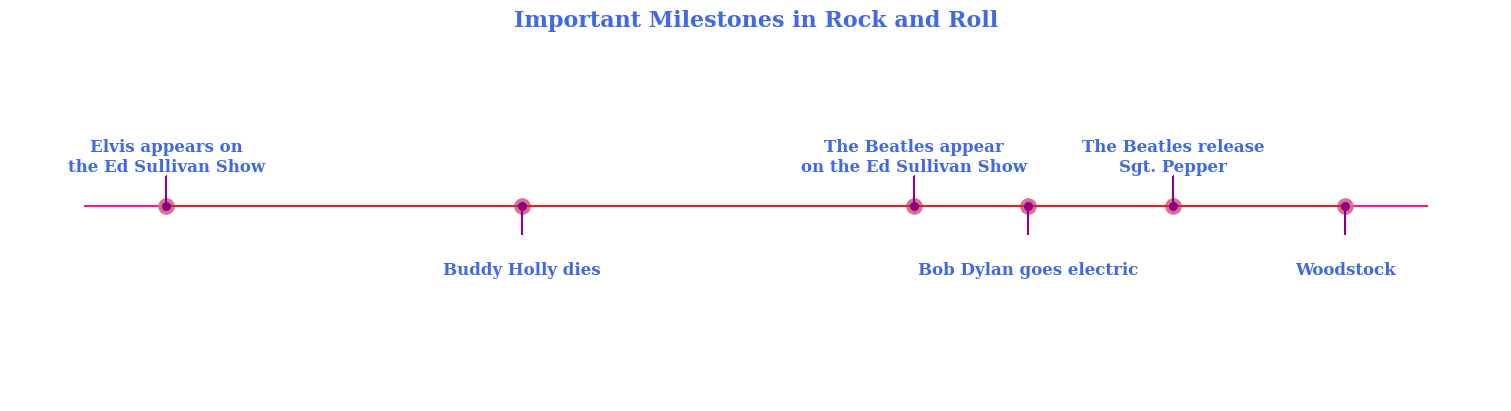

In [15]:
import timeline
from datetime import date

dates = {
    date(1954, 7, 19):'Elvis appears on\nthe Ed Sullivan Show', 
    date(1959, 2, 3):'Buddy Holly dies', 
    date(1964, 2, 9):'The Beatles appear\non the Ed Sullivan Show', 
    date(1965, 7, 25):'Bob Dylan goes electric', 
    date(1967, 6, 1):'The Beatles release\nSgt. Pepper', 
    date(1969, 8, 15):'Woodstock'
}
timeline.plot_timeline(dates, 'Important Milestones in Rock and Roll')

# Ajouter un stamp à un pdf.

In [44]:
from pathlib import Path
from typing import Union, Literal, List

from pypdf import PdfWriter, PdfReader, Transformation


def stamp_pdf(
    content_pdf: Path,
    stamp_pdf: Path,
    pdf_result: Path,
    page_indices: Union[Literal["ALL"], List[int]] = "ALL",
):
    stamp_page = PdfReader(stamp_pdf).pages[0]
    writer = PdfWriter()
    reader = PdfReader(content_pdf)
    
    if page_indices == "ALL":
        page_indices = list(range(0, len(reader.pages)))
        
    for index in page_indices:
        content_page = reader.pages[index]
        content_page.merge_transformed_page(
            stamp_page,
            Transformation().scale(sx=0.2, sy=0.2).translate(tx=700, ty=0),
            over=True
        )
        writer.add_page(content_page)

    with open(pdf_result, "wb") as fp:
        writer.write(fp)

In [30]:
import python.stamper as stamper

my_stamper = stamper.BasicStamper(stamp_pdf='data/test_utils/stamp_test.pdf')

my_stamper.stamp(
    input_pdf='data/test_utils/Candidature.pdf',
    output_pdf='data/test_utils/stamped_pdf_test.pdf', stamped_page_indices=[0])

# Fusionner des immages png avec transparence

In [3]:
# import PIL module
from PIL import Image
  
# Définir les chemins.
background = 'data/test_utils/Screenshot_20221110_104831.png'
front = 'data/test_utils/Approved-stamp-on-transparent-PNG.png'
  
# Ouvrir l'image supérieure.
frontImage = Image.open(front)
frontImage = frontImage.reduce(factor=8)
  
# Ouvrir l'image de fond.
background = Image.open(background)
  
# Convert image to RGBA
frontImage = frontImage.convert("RGBA")
background = background.convert("RGBA")
  
# Calculer les coordonnées de l'image collée.
width = (background.width - frontImage.width) // 2
height = (background.height - frontImage.height) // 2
  
# Coller l'image supérieur aux coordonnées indiquées (width, height)
background.paste(frontImage, (width, height), frontImage)
  
# Sauvegarder l'image composée.
background.save("data/test_utils/new.png", format="png")

Modifier ajouter du texte sur une image

In [4]:
from PIL import Image, ImageDraw, ImageFont

# create an image
out = Image.new("RGB", (150, 100), (255, 255, 255))

# get a font
fnt = ImageFont.truetype("Pillow/Tests/fonts/FreeMono.ttf", 40)
# get a drawing context
d = ImageDraw.Draw(out)

# draw multiline text
d.multiline_text((10, 10), "Hello\nWorld", font=fnt, fill=(0, 0, 0))

out.show()

In [ ]:
from PIL import Image, ImageDraw, ImageFont

def generate_indexed_stamp(base_stamp, w_h_pos, start_index=1, opacity=255)

for i in range(2):

    # Modifier une image existante.
    with Image.open("data/test_utils/Approved-stamp-on-transparent-PNG.png").convert("RGBA") as base:

        # make a blank image for the text, initialized to transparent text color
        txt = Image.new("RGBA", base.size, (255, 255, 255, 0))

        # get a font
        fnt = ImageFont.truetype("Pillow/Tests/fonts/FreeMono.ttf", 70)

        # get a drawing context
        d = ImageDraw.Draw(txt)

        # draw text, half opacity
        d.text((txt.width/2, txt.height/2), "Hello", font=fnt, fill=(255, 255, 255, 128))
        
        # draw text, full opacity
        d.text((txt.width/2, txt.height/2+50), "World", font=fnt, fill=(255, 255, 255, 255))
        
        # draw text, full opacity
        d.text((txt.width/2, txt.height/2+100), str(i), font=fnt, fill=(255, 255, 255, 255))

        out = Image.alpha_composite(base, txt)

        out.show()

In [40]:
from PIL import Image, ImageDraw, ImageFont
import pathlib


    
generate_indexed_stamp()

'data/test_utils/temp_idx_stamp.png'

# Convertr des pages pdf en images

In [2]:
# import module
from pdf2image import convert_from_path
 
 
# Store Pdf with convert_from_path function
images = convert_from_path('data/test_utils/pdf_test.pdf')
 
for i in range(len(images)):
   
      # Save pages as images in the pdf
    images[i].save('data/test_utils/page'+ str(i) +'.jpg', 'JPEG')

# créer un pdf à partir d'images

In [ ]:
from PIL import Image


images_stem = 'data/test_utils/page0.jpg'

image_1 = Image.open(r'data/test_utils/page0.jpg')
image_2 = Image.open(r'data/test_utils/page1.jpg')
image_3 = Image.open(r'data/test_utils/page2.jpg')
image_4 = Image.open(r'data/test_utils/page3.jpg')

im_1 = image_1.convert('RGB')
im_2 = image_2.convert('RGB')
im_3 = image_3.convert('RGB')
im_4 = image_4.convert('RGB')

image_list = [im_2, im_3, im_4]

im_1.save(r'data/test_utils/rebuilt_from_images.pdf', save_all=True, append_images=image_list)

In [33]:
from PIL import Image

output = 'data/test_utils/tampon_transparent_boissy.pdf'

stamp_base = 'data/test_utils/tampon_boissy.png'
my_image = Image.open(stamp_base)
my_image = my_image.convert('RGB')
my_image = my_image.alpha_composite()
current_alpha = my_image.getchannel('A')
new_alpha = current_alpha.point(lambda i: 128 if i>0 else 0)
my_image.putalpha(new_alpha)
my_image.save(output)

ValueError: The image has no channel "A"

In [37]:
from PIL import Image, ImageDraw, ImageFont
import pathlib

def generate_indexed_stamp(base_stamp, w_h_pos='default', index=1, color_opacity=(0, 0, 0, 255), output= 'data/test_utils/tampon_transparent_boissy.png'):

    base_stamp = pathlib.Path(base_stamp)

    # Modifier le tampon de base.
    with Image.open(base_stamp).convert("RGBA") as base:

        # make a blank image for the text, initialized to transparent text color
        txt = Image.new("RGBA", base.size, (255, 255, 255, 0))

        # get a font
        fnt = ImageFont.truetype("Pillow/Tests/fonts/FreeMono.ttf", round(txt.height/3))

        # get a drawing context
        d = ImageDraw.Draw(txt)

        # draw text, full opacity
        d.text((txt.width/2, txt.height/2+100), str(index), font=fnt, fill=color_opacity)

        # Recomposer une image avec le tampon de base et le texte.
        out = Image.alpha_composite(base, txt)

        # Load image and extract alpha channel
        current_alpha = out.getchannel('A')

        # Make all opaque pixels into semi-opaque
        new_alpha = current_alpha.point(lambda i: 128 if i>0 else 0)
        out.putalpha(new_alpha)

        out.save(output)

    return output

generate_indexed_stamp('data/test_utils/tampon_boissy.png')

'data/test_utils/tampon_transparent_boissy.png'

In [ ]:
import python.office_suites_utils.pdf_utils as pdf_utils
from pdf2image import convert_from_path
import os


def generate_indexed_stamp(base_stamp, w_h_pos='default', index=1, color_opacity=(0, 0, 0, 255), output='data/test_utils/temp_idx_stamp.png'):
    
    base_stamp = pathlib.Path(base_stamp)

    # Modifier une image existante.
    with Image.open(base_stamp).convert("RGBA") as base:

        # make a blank image for the text, initialized to transparent text color
        txt = Image.new("RGBA", base.size, (255, 255, 255, 0))


        # get a font
        fnt = ImageFont.truetype("Pillow/Tests/fonts/FreeMono.ttf", round(txt.height/3))

        # get a drawing context
        d = ImageDraw.Draw(txt)

        # draw text, full opacity
        d.text((txt.width/2, txt.height/2+100), str(index), font=fnt, fill=color_opacity)

        out = Image.alpha_composite(base, txt)
        
        out.save(output)
    
    return output

def advanced_stamp(background, stamp, w_h_pos='default', output="data/test_utils/new.png"):

    # Ouvrir l'image supérieure.
    frontImage = Image.open(stamp)
    frontImage = frontImage.reduce(factor=8)

    # Ouvrir l'image de fond.
    background = Image.open(background)

    # Convert image to RGBA
    frontImage = frontImage.convert("RGBA")
    background = background.convert("RGBA")

    # Calculer les coordonnées de l'image collée.
    width = (background.width - frontImage.width) // 2
    height = (background.height - frontImage.height) // 2

    # Coller l'image supérieur aux coordonnées indiquées (width, height)
    background.paste(frontImage, (width, height), frontImage)

    # Sauvegarder l'image composée.
    background.save(output, format="png")

def lawyer_stamper(pdf_file, output, stamp_file, w_h_pos='default', start_index=1, stamped_pages='all'):
    
    pdf_file = pathlib.Path(pdf_file)

    # Convertir  le pdf en images.
    images = convert_from_path(pdf_file)
    
    # Itérer sur les images.
    temp_images = []
    for i, image in enumerate(images):

        # Enregistrer la page comme une image jpeg.
        temp_image = f'{pdf_file.parents[0]}/page{str(i)}.jpg'
        image.save(temp_image, 'JPEG')
        
        # Générer le tampon indexé.
        temp_stamp = generate_indexed_stamp(base_stamp=stamp_file, index=start_index)
        
        # Tamponner les pages requises uniqument les pages requises.
        if stamped_pages == 'all' or i + 1 in stamped_pages:
            # Insérer le tampon et enregistrer la nouvelle image.
            advanced_stamp(background=temp_image, stamp=temp_stamp, output=temp_image)
        
        temp_images.append(temp_image)

    # Reconstruire le pdf à partir des images.
    pil_image_objects = []
    for i, image in enumerate(temp_images):
        pil_image_objects.append(Image.open(image).convert('RGB'))
    pil_image_objects[0].save(output, save_all=True, append_images=pil_image_objects[1:])
    
    for image in temp_images:
        os.remove(image)
    
    return output

lawyer_stamper('data/test_utils/pdf_test.pdf', 'data/test_utils/stamped_file.pdf', "data/test_utils/Approved-stamp-on-transparent-PNG.png", start_index=2, stamped_pages=[1,3])

In [79]:
import python.office_suites_utils.pdf_utils as pdf_utils
from pdf2image import convert_from_path
from PIL import Image, ImageDraw, ImageFont
import pathlib
import os
import logging
import re

def generate_indexed_stamp(base_stamp, w_h_pos='default', index=1, color_opacity=(0, 0, 0, 255), output='data/test_utils/temp_idx_stamp.png'):
    
    base_stamp = pathlib.Path(base_stamp)

    # Modifier une image existante.
    with Image.open(base_stamp).convert("RGBA") as base:

        # make a blank image for the text, initialized to transparent text color
        txt = Image.new("RGBA", base.size, (255, 255, 255, 0))

        # get a font
        fnt = ImageFont.truetype("Pillow/Tests/fonts/FreeMono.ttf", round(txt.height/3))

        # get a drawing context
        d = ImageDraw.Draw(txt)

        # draw text, full opacity
        d.text((txt.width/2, txt.height/2+100), str(index), font=fnt, fill=color_opacity)

        out = Image.alpha_composite(base, txt)
        
        # Load image and extract alpha channel
        current_alpha = out.getchannel('A')

        # Make all opaque pixels into semi-opaque
        new_alpha = current_alpha.point(lambda i: 128 if i>0 else 0)
        out.putalpha(new_alpha)
        
        out.save(output)
    
    return output

def advanced_stamp(background, stamp, resize=1, w_h_pos='default', output="data/test_utils/new.png"):

    # # Définir les chemins.
    # background = 'data/test_utils/Screenshot_20221110_104831.png'
    # front = 'data/test_utils/Approved-stamp-on-transparent-PNG.png'

    # Ouvrir l'image supérieure.
    frontImage = Image.open(stamp)
    # frontImage = frontImage.reduce(factor=8)
    if resize != 1:
        frontImage = frontImage.resize((
            round(frontImage.width*resize), 
            round(frontImage.height*resize)
            ))

    # Ouvrir l'image de fond.
    background = Image.open(background)
    
    # Calculer les coordonnées de l'image collée.
    if w_h_pos == 'default':
        w_h_pos = (
            background.width - frontImage.width,
            0
        )
    else:
        w_h_pos = (
           (background.width - frontImage.width) // 2,
            (background.height - frontImage.height) // 2
        )
        
    # Convert image to RGBA
    frontImage = frontImage.convert("RGBA")
    background = background.convert("RGBA")

    # Coller l'image supérieur aux coordonnées indiquées (width, height)
    background.paste(frontImage, w_h_pos, frontImage,)

    # Sauvegarder l'image composée.
    background.save(output, format="png")

def lawyer_stamper(pdf_file, stamp_file, output='same_as_source', resize=1, w_h_pos='default', start_index=1, stamped_pages='all'):
    
    if isinstance(pdf_file, pathlib.Path) is False:
        pdf_file = pathlib.Path(pdf_file)

    # Convertir  le pdf en images.
    images = convert_from_path(pdf_file)
    
    # Itérer sur les images.
    pil_image_objects = []
    for i, image in enumerate(images):

        # Enregistrer la page comme une image jpeg.
        temp_image_path = f'{pdf_file.parents[0]}/page{str(i)}.jpg'
        image.save(temp_image_path, 'JPEG')
        
        # Générer le tampon indexé.
        temp_stamp = generate_indexed_stamp(base_stamp=stamp_file, index=start_index)
        
        # Tamponner uniqument les pages requises.
        if stamped_pages == 'all' or i + 1 in stamped_pages:
            advanced_stamp(background=temp_image_path, stamp=temp_stamp, resize=resize, output=temp_image_path)
        
        # Ajouter la nouvelle image tamponnée en tant qu'objet PIL à la liste des images qui serviront à recontruire le pdf.
        pil_image_objects.append(Image.open(temp_image_path).convert('RGB'))
        
        # Supprimer l'image temporaire.
        os.remove(temp_image_path)
    os.remove(temp_stamp)

    # Reconstruire le pdf à partir des images.
    if output == 'same_as_source':
        output = pdf_file
    pil_image_objects[0].save(output, save_all=True, append_images=pil_image_objects[1:])
    
    return output

def get_document_index(document):
    
    RGX_DOC_INDEX = re.compile('(^\d+)(_.*)', re.DOTALL)
    
    # Récupérer les documents à tamponner.
    document = pathlib.Path(document)
    
    # Déterminer le numéro de pièce correspondant au document.
    doc_index = RGX_DOC_INDEX\
        .search(pathlib.Path(document).name)\
        .expand(r'\1')
    
    return int(doc_index)
    
def documents_lawyer_stamper(docs_folder, stamp, output='same_as_source', resize=1, stamped_pages='all'):
    
    RGX_DOC_INDEX = re.compile('(^\d+)(_.*)', re.DOTALL)
    
    # Récupérer les documents à tamponner.
    documents = pathlib.Path(docs_folder).glob('*.pdf')
    documents = [_ for _ in documents if RGX_DOC_INDEX.search(_.name)]
       
    # Itérer sur les documents.
    for document in documents:
        print(document, output, stamp)
        lawyer_stamper(
            pdf_file=document, 
            output=output, 
            stamp_file=stamp, 
            resize=resize,
            start_index=get_document_index(document), 
            stamped_pages=stamped_pages
        )

docs_folder = 'data/test_utils'
stamp = "data/test_utils/tampon_boissy.png"
stamped_pages='all' 

documents_lawyer_stamper(
    docs_folder=docs_folder, 
    stamp=stamp, 
    resize=0.65,
    stamped_pages=[1,3]
)

data/test_utils/1_doc.pdf same_as_source data/test_utils/tampon_boissy.png


In [52]:
from python import stamper

docs_folder = 'data/test_utils'
stamp = "data/test_utils/tampon_boissy.png"
stamped_pages='all' 

stamper.documents_lawyer_stamper(
    docs_folder=docs_folder, 
    stamp=stamp, 
    resize=0.65,
    stamped_pages=[1,3]
)

data/test_utils/1_doc.pdf same_as_source data/test_utils/tampon_boissy.png


In [28]:
# Modifier autocorr libre office

import re
import zipfile
import shutil
import pathlib
import sqlite3

output_dat_file = 'data/libreoffice/acor_fr-FR.dat'
shutil.copy('data/libreoffice/backups/acor_fr-FR.dat', output_dat_file)

xml_rgx_pattern = re.compile('(<block-list:block-list xmlns:block-list="http://openoffice.org/2001/block-list">)(.*)(</block-list:block-list>)', re.DOTALL|re.MULTILINE)

with sqlite3.connect('data/autocorrect_autotext.db') as cnx:
    csr = cnx.cursor()
    sql = "SELECT shortcut, replace FROM tbl_autocorrect WHERE replace IS NOT NULL AND is_autocorrect IS TRUE ;"
    q_results = csr.execute(sql)
    
with open('data/libreoffice/backups/acor_fr-FR/DocumentList.xml') as xml_file:
    xml = xml_file.read()
    xml_rgx_search_obj = xml_rgx_pattern.search(xml)
    former_xml_header = xml_rgx_search_obj.expand(r'\1')
    former_xml_content = xml_rgx_pattern.search(xml).expand(r'\2')
    former_xml_tailer = xml_rgx_search_obj.expand(r'\3')

new_xml_content = former_xml_content
for text,repl_text in q_results:
    
    new_line = f'<block-list:block block-list:abbreviated-name="{text}" block-list:name="{repl_text}"/>'
    new_xml_content += new_line

new_xml = former_xml_header + new_xml_content + former_xml_tailer

with open('data/libreoffice/DocumentList.xml', 'w') as new_xml_file:
    new_xml_file.write(new_xml)
    
with zipfile.ZipFile(output_dat_file, 'w') as zip_file:
    zip_file.write('data/libreoffice/backups/acor_fr-FR/mimetype', 'mimetype')
    zip_file.write('data/libreoffice/backups/acor_fr-FR/SentenceExceptList.xml', 'SentenceExceptList.xml')
    zip_file.write('data/libreoffice/backups/acor_fr-FR/WordExceptList.xml', 'WordExceptList.xml')
    zip_file.write('data/libreoffice/backups/acor_fr-FR/META-INF/manifest.xml', 'META-INF/manifest.xml')
    zip_file.write('data/libreoffice/DocumentList.xml', 'DocumentList.xml')
    
shutil.move(output_dat_file, '/home/alex/.config/libreoffice/4/user/autocorr/acor_fr-FR.dat')

'/home/alex/.config/libreoffice/4/user/autocorr/acor_fr-FR.dat'

In [50]:
import sqlite3
import pathlib
import os

DB_AUTOCORRECT_AUTOTEXT = 'data/libreoffice/autocorrect_autotext.db'
TBL_AUTOCORRECT = 'tbl_autocorrect'

def create_db():

    if pathlib.Path(DB_AUTOCORRECT_AUTOTEXT).exists():
        os.remove(DB_AUTOCORRECT_AUTOTEXT)

    with sqlite3.connect(DB_AUTOCORRECT_AUTOTEXT) as cnx:
        csr = cnx.cursor()
        
        sql = f"""CREATE TABLE {TBL_AUTOCORRECT} (
        "shortcut"  TEXT UNIQUE,
        "replace" TEXT PRIMARY KEY NOT NULL,
        "is_autocorrect" BOOLEAN NOT NULL DEFAULT 0
        );"""

        csr.execute(sql)
        cnx.commit()

def insert_row(replace, is_autocorrect, shortcut=None):

    with sqlite3.connect(DB_AUTOCORRECT_AUTOTEXT) as cnx:
        csr = cnx.cursor()
        
        sql_check = f"""
        SELECT * 
        FROM {TBL_AUTOCORRECT} 
        WHERE shortcut=? ;
        """
        rows = csr.execute(sql_check, (shortcut,)).fetchall()
        
        if len(rows):
            sql_insert_update = f"""
            UPDATE {TBL_AUTOCORRECT} 
            SET shortcut=?, replace=?, is_autocorrect=?
            WHERE shortcut=? ;
            """
            csr.execute(sql_insert_update, (shortcut, replace, is_autocorrect, shortcut)) 
        else:  
            sql_insert_update = f"""
            INSERT INTO {TBL_AUTOCORRECT} 
            VALUES (?, ?, ?);
            """
            csr.execute(sql_insert_update, (shortcut, replace, is_autocorrect))
        cnx.commit()
    
insert_row(shortcut='%cpp', replace='d', is_autocorrect=True)

In [52]:
from bs4 import BeautifulSoup
import re

with open('data/test_utils/Codes - Légifrance.html') as html_file:
    soup = BeautifulSoup(html_file, 'html.parser')
    
codes = soup.find_all('a', id=re.compile('idLEGITEXT.*'))

rows_sql_insert = [(None, _.text, True) for _ in codes]
with sqlite3.connect(DB_AUTOCORRECT_AUTOTEXT) as cnx:
    csr = cnx.cursor()
    
    sql_insert = f"""INSERT INTO {TBL_AUTOCORRECT} VALUES(?, ?, ?);"""
    csr.executemany(sql_insert, rows_sql_insert)


In [11]:

# nommer automatiquement les pièces.
# créer les modèles de mémoires.

# créer des autotextes customisé qui vont chercher l'information en direct sur internet. essayer sur les articles légifrance.

'data/libreoffice/acor_fr-FR.dat'

In [32]:
import webbrowser

browser = webbrowser.get()
print(dir(browser))
print(browser.background)
browser.name

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_invoke', 'args', 'background', 'basename', 'name', 'open', 'open_new', 'open_new_tab', 'raise_opts', 'redirect_stdout', 'remote_action', 'remote_action_newtab', 'remote_action_newwin', 'remote_args']
True


'firefox'

In [2]:
import subprocess

# récupérer le focus placé sur l'url.        # Vider le presse papier de xsel.
subprocess.run('xsel -cb', shell=True)
focus_output = subprocess.check_output(
    "xsel", universal_newlines=True).strip().replace('\n', ' ')
focus_output

# récupérer le code html de la page.

# demander à l'utilisateur la partie de texte qu'il veut conserver (boucle si plusieurs paragraphe discontinus)

# générer un json avec les informations utiles.

KeyboardInterrupt: 

In [ ]:
# Créer la table pour les raccourcis

In [42]:
from pypdf import PdfWriter, PdfReader, Transformation

pdf = PdfReader('data/test_utils/1_doc.pdf')
pdf.pages[1]

{'/Resources': {'/ProcSet': ['/PDF', '/ImageC'],
  '/XObject': {'/image': {'/Type': '/XObject',
    '/Subtype': '/Image',
    '/Width': 1653,
    '/Height': 2339,
    '/Filter': '/DCTDecode',
    '/BitsPerComponent': 8,
    '/ColorSpace': '/DeviceRGB'}}},
 '/MediaBox': [0, 0, 1653, 2339],
 '/Contents': {},
 '/Type': '/Page',
 '/Parent': {'/Type': '/Pages',
  '/Count': 3,
  '/Kids': [IndirectObject(2, 0, 140346907042960),
   IndirectObject(5, 0, 140346907042960),
   IndirectObject(8, 0, 140346907042960)]}}

### LayerDocBuilder

In [106]:
import re
import subprocess

In [264]:
doc = 'docx_to_md_test.md'
with open(doc) as file:
    raw_text = file.read()

In [108]:
RGX_PTRN_BLOCK = re.compile(r'(\\<section\\>)(.*)(\\</section\\>)', re.DOTALL|re.MULTILINE)
blocks = RGX_PTRN_BLOCK.findall(raw_text)

In [109]:
sections = []
for _ in raw_text.split('\\</section\\>'):
    temp_match = RGX_PTRN_BLOCK.search(_ + '\\</section\\>')
    if temp_match:
        sections.append(temp_match.expand(r'\2'))

sections

["\n\n\\<h1\\>\n\nI.  **Sur la notion de «\xa0conflit d'intérêt\xa0».**\n\n\\</h1\\>\n\nUne dizaine de textes ont été adoptés depuis la loi n°2013 -907 du 11\noctobre 2013 relative à la transparence de la vie publique. Tous ont\nvocation à renforcer la prévention des conflits d'intérêts (lois et\ndécrets relatifs à la déontologie, à la transparence, à la lutte contre\nla corruption et à la modernisation de la vie économique, au référent\ndéontologue, et lanceurs d'alerte, loi pour la confiance dans la vie\npolitique, etc.).\n\nLe «\xa0conflit d'intérêt\xa0», notion clé de cette nouvelle législation, est\nune notion transversale qui intéresse à la fois le droit administratif\net le droit pénal. Elle a fait l'objet d'évolutions assez récentes en\nraison des divergences d'interprétation constatées entre les\njuridictions administratives et judiciaires.\n\nLa définition du conflit d'intérêt est donnée par l'article 2 de la loi\nn° 2013-907 du 11 octobre 2013 relative à la transparence de l

In [222]:
raw_text = raw_text.replace('\n>','\n')
paragraphs = raw_text.split('\n\n')
paragraphs

['**COMMUNE SAINT JOSEPH**',
 '**227, rue du Général Lambert**',
 '**97480 SAINT-JOSEPH**',
 'Bordeaux, le 6 avril 2023',
 ' **[N/Réf.]{.underline}\xa0: 972923 - CNE SAINT JOSEPH - CONSULTATIONS**',
 " **[Objet]{.underline}\xa0: Consultation sur un potentiel conflit\n d'intérêt.**",
 ' Monsieur le Maire,',
 "Vous sollicitez notre avis concernant une problématique relative à un\néventuel conflit d'intérêt du maire de la COMMUNE DE SAINT-JOSEPH qui\npourrait se matérialiser lors de votre prochain conseil municipal.",
 "L'organe délibérant de la collectivité doit en effet délibérer sur\nl'opportunité de conclure une convention de portage avec l'Etablissement\nPublic Foncier de la Réunion (EPFR) en vue de l'acquisition d'une\nparcelle à transformer en parking dans le cadre de travaux d'aménagement\nd'une des artères principales de la ville (Rue du Général de Gaulle).",
 "Cette délibération doit avoir lieu lors d'une séance dont l'objet ne\nporte pas uniquement sur cette question.",
 "Votre

In [223]:
len(paragraphs)

222

In [315]:
def get_sections(paragraphs, start_enumerate=0):
    
    if '\\<section\\>' not in paragraphs:
        return
    
    open_tag_count = 0
    close_tag_count = 0
    first_index = None
    parsed_sections = []
    for i, line in enumerate(paragraphs, start=start_enumerate):
        if '\\<section\\>' in line:
            open_tag_count += 1
            if first_index is None:
                first_index = i+1
        elif '\\</section\\>' in line:
            close_tag_count += 1
        
        # Tester si la section est complète en vérifier qu'elle contient autant de balises ouvrantes que fermantes.
        if open_tag_count == close_tag_count and open_tag_count >= 1 and close_tag_count >= 1:
            parsed_sections.append((first_index, i))
                    
            first_index = None
            open_tag_count = 0
            close_tag_count = 0

            
    # print((open_tag_count, close_tag_count))
    return parsed_sections



In [316]:
parsed_section = get_sections(paragraphs)
parsing_sections = parsed_section
fully_parsed_sections = []

while len(parsing_sections):
    still_parsing_sections = []
    for start,end in parsing_sections:
        result = get_sections(paragraphs[start:end], start)
        if result is None:
            fully_parsed_sections.append((start,end))
        else:
            fully_parsed_sections.append((start,end))
            still_parsing_sections.extend(result)
            
    parsing_sections = still_parsing_sections

sorted(fully_parsed_sections)

[(17, 52),
 (56, 101),
 (105, 202),
 (116, 166),
 (144, 159),
 (148, 152),
 (154, 158),
 (161, 165),
 (169, 199),
 (206, 215)]

In [314]:
print('\n\n'.join(paragraphs[161: 165]))

\<h2\>

2 Titre 2

\</h2\>

lorem impsum


In [121]:
# Reconstruire le document
selected_section = (cleaned_sections[0], cleaned_sections[2])
rebuilt_doc = ''

for section in selected_section:
    # !!! appliquer la sélection des lignes !!!
    if len(rebuilt_doc):
        rebuilt_doc += '\n\n' + '\n\n'.join(section)
    else:
        rebuilt_doc = '\n\n'.join(section)



\<h1\>

I.  **Sur la notion de « conflit d'intérêt ».**

\</h1\>

Une dizaine de textes ont été adoptés depuis la loi n°2013 -907 du 11 octobre 2013 relative à la transparence de la vie publique. Tous ont vocation à renforcer la prévention des conflits d'intérêts (lois et décrets relatifs à la déontologie, à la transparence, à la lutte contre la corruption et à la modernisation de la vie économique, au référent déontologue, et lanceurs d'alerte, loi pour la confiance dans la vie politique, etc.).

Le « conflit d'intérêt », notion clé de cette nouvelle législation, est une notion transversale qui intéresse à la fois le droit administratif et le droit pénal. Elle a fait l'objet d'évolutions assez récentes en raison des divergences d'interprétation constatées entre les juridictions administratives et judiciaires.

La définition du conflit d'intérêt est donnée par l'article 2 de la loi n° 2013-907 du 11 octobre 2013 relative à la transparence de la vie publique.

\<blockquote\>

 **Loi n

In [123]:
with open('export_block.md', 'w') as file:
    file.write(rebuilt_doc)

subprocess.Popen(('pandoc', '-s', 'export_block.md', '-t', 'docx', '-o', 'export_block.docx'))

<Popen: returncode: None args: ('pandoc', '-s', 'export_block.md', '-t', 'do...>

[WARNING] Could not fetch resource media/image1.png: replacing image with description
